Author: Vinícius Tertulino Parede

Contact: vinicius.parede@ppgia.pucpr.br

# Libraries

In [84]:
import pandas as pd
import numpy as np

# Pre-processing
from sklearn.preprocessing import StandardScaler

# Metrics
from sklearn.metrics import confusion_matrix

# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

# Models Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

# Load Data

In [85]:
# load data
csv_link = "https://archive.ics.uci.edu/ml/machine-learning-databases/00519/heart_failure_clinical_records_dataset.csv"
df = pd.read_csv(csv_link)
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [86]:
variables = ["anaemia", "high_blood_pressure", "diabetes", "sex", "smoking"]
summary_list = []

# Iterate over selected variables
for var in variables:
    # Calculate counts and percentages for the full sample
    full_sample_count = df[var].value_counts()
    full_sample_percent = df[var].value_counts(normalize=True) * 100

    # Calculate counts and percentages for patients who died
    dead_sample_count = df[df["DEATH_EVENT"] == 1][var].value_counts()
    dead_sample_percent = (
        df[df["DEATH_EVENT"] == 1][var].value_counts(normalize=True) * 100
    )

    # Calculate counts and percentages for patients who survived
    survived_sample_count = df[df["DEATH_EVENT"] == 0][var].value_counts()
    survived_sample_percent = (
        df[df["DEATH_EVENT"] == 0][var].value_counts(normalize=True) * 100
    )

    # Create temporary DataFrame for each variable and value
    for val in [0, 1]:
        temp_df = pd.DataFrame(
            {
                "Variable": var,
                "Bool": val,
                "Full Sample #": full_sample_count.get(val, 0),
                "Full Sample %": full_sample_percent.get(val, 0),
                "Dead Patients #": dead_sample_count.get(val, 0),
                "Dead Patients %": dead_sample_percent.get(val, 0),
                "Survived Patients #": survived_sample_count.get(val, 0),
                "Survived Patients %": survived_sample_percent.get(val, 0),
            },
            index=[0],
        )
        summary_list.append(temp_df)

# Concatenate all temporary DataFrames into a single summary DataFrame
summary_df = pd.concat(summary_list, ignore_index=True)
summary_df = summary_df.round(2)
summary_df

,Variable,Bool,Full Sample #,Full Sample %,Dead Patients #,Dead Patients %,Survived Patients #,Survived Patients %
0,anaemia,0,170,56.86,50,52.08,120,59.11
1,anaemia,1,129,43.14,46,47.92,83,40.89
2,high_blood_pressure,0,194,64.88,57,59.38,137,67.49
3,high_blood_pressure,1,105,35.12,39,40.62,66,32.51
4,diabetes,0,174,58.19,56,58.33,118,58.13
5,diabetes,1,125,41.81,40,41.67,85,41.87
6,sex,0,105,35.12,34,35.42,71,34.98
7,sex,1,194,64.88,62,64.58,132,65.02
8,smoking,0,203,67.89,66,68.75,137,67.49
9,smoking,1,96,32.11,30,31.25,66,32.51


# A) Model Construction
Find the best solution for this problem through the evaluation of monolithic solutions (using a single model). For this, evaluate the techniques studied in class (KNN, Naive Bayes, Decision Trees, SVM and MLP). Use cross-validation considering 5 folds. Record in the table below the model with the best result, give preference to the most suitable metric considering the problem at hand.

## Preprocessing Data

In [87]:
columns = df.columns
target = "DEATH_EVENT"
features = columns.drop(target)

# Specify the columns that are the independent variables (X) and the dependent variable (y)
X = df.loc[:, features].copy()
y = df.loc[:, target].copy()

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [88]:
print("Train instances: ", X_train.shape[0])
print("Validation instances: ", X_val.shape[0])

Train instances:  239
Validation instances:  60


WARNING!
The code snippet below modifies the final answer.

In [89]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Apply the StandardScaler to the entire DataFrame
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_val)

# The result will be a NumPy array. If desired, you can convert it back to a DataFrame:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val_scaled = pd.DataFrame(X_test_scaled, columns=X_val.columns)

## Model Selection

In [90]:
def find_best_model(X: pd.DataFrame, y: pd.Series) -> dict:
    models = {
        "KNN": KNeighborsClassifier(),
        "Naive Bayes": GaussianNB(),
        "Decision Tree": DecisionTreeClassifier(),
        "SVM": svm.SVC(),
        "MLP": MLPClassifier(),
    }

    # Define the hyperparameters
    param_grid = {
        "KNN": {"n_neighbors": [3, 5, 7, 9, 11], "weights": ["uniform", "distance"]},
        "Naive Bayes": {},  # No hyperparameters to be adjusted for Naive Bayes
        "Decision Tree": {
            "ccp_alpha": [0.01],
            "criterion": ["gini"],
            "max_depth": [6],
            "max_features": [None],
            "min_samples_split": [4],
            "splitter": ["random"],
        },
        "SVM": {
            "C": [0.1, 1, 10],
            "gamma": [1, 0.1, 0.01],
            "kernel": ["linear", "rbf"],
        },
        "MLP": {
            "hidden_layer_sizes": [(100,), (200,)],
            "activation": ["relu", "tanh", "logistic"],
            "max_iter": [5000],
            "alpha": [0.0001],
        },
    }

    best_models = {}
    for name_model, model in models.items():
        gs = GridSearchCV(model, param_grid[name_model], cv=5, scoring="accuracy")
        gs.fit(X, y)

        best_models[name_model] = {
            "best_estimator": gs.best_estimator_,
            "accuracy": np.round(
                cross_val_score(gs, X, y, cv=5, scoring="accuracy").mean(), 3
            ),
            "f1_score": np.round(
                cross_val_score(gs, X, y, cv=5, scoring="f1_macro").mean(), 3
            ),
        }

    return best_models

In [91]:
best_models = find_best_model(X=X_train_scaled, y=y_train)
best_models

{'KNN': {'best_estimator': KNeighborsClassifier(),
  'accuracy': 0.741,
  'f1_score': 0.646},
 'Naive Bayes': {'best_estimator': GaussianNB(),
  'accuracy': 0.753,
  'f1_score': 0.669},
 'Decision Tree': {'best_estimator': DecisionTreeClassifier(ccp_alpha=0.01, max_depth=6, min_samples_split=4,
                         splitter='random'),
  'accuracy': 0.812,
  'f1_score': 0.797},
 'SVM': {'best_estimator': SVC(C=1, gamma=1, kernel='linear'),
  'accuracy': 0.841,
  'f1_score': 0.814},
 'MLP': {'best_estimator': MLPClassifier(activation='logistic', hidden_layer_sizes=(200,), max_iter=5000),
  'accuracy': 0.828,
  'f1_score': 0.805}}

# B) Respond based on the studied techniques and observed results:

## B.1) How many instances are there in the database provided by the company?

In [103]:
print("Instances: ", df.shape[0])

Instances:  299


## B.2) How many input attributes form each instance of the database?

In [104]:
print("Attributes: ", X.shape[1])

Attributes:  12


## B.3) How many examples of each class are there in the database?

In [105]:
print("Survived patients: ", df.loc[df[target] == 0].shape[0])
print("Death patients: ", df.loc[df[target] == 1].shape[0])

Survived patients:  203
Death patients:  96


## B.4) In the table above, you presented your best model. Justify your choice

The F1-Score is a metric used to evaluate the performance of a classification model, especially in cases where the dependent variable in the database is imbalanced. It combines the metrics of precision and recall into a single value, providing a balanced measure of the model's performance.

Precision measures the proportion of instances classified as positive that are actually positive, while recall measures the proportion of positive instances that are correctly identified by the model. The F1-Score is the harmonic mean of precision and recall, and it takes into account both metrics to provide an overall assessment of the model's effectiveness in handling imbalanced data.

## B.5) Please present the confusion matrix of the model indicated in the table and fill it out below:

In [106]:
models = {model: best_models.get(model) for model in best_models.keys()}

best_model = max(models.values(), key=lambda x: x["accuracy"])


print("Training Confusion Matrix")
y_pred = cross_val_predict(
    estimator=best_model.get("best_estimator"), X=X_train_scaled, y=y_train, cv=5
)
cm = confusion_matrix(y_true=y_train, y_pred=y_pred)
print(cm)

tn, fp, fn, tp = cm.ravel()

print("\nTrue Positive (TP):", tp)
print("False Positive (FP):", fp)
print("True Negative (TN):", tn)
print("False Negative (FN):", fn)
print("")

tvp = tp / (tp + fn)
tfp = fp / (fp + tn)
tvn = tn / (tn + fp)
tfn = fn / (fn + tp)

print("True Positive Rate (TVP):", np.round(tvp, 2))
print("False Positive Rate (TFP):", np.round(tfp, 2))
print("True Negative Rate (TVN):", np.round(tvn, 2))
print("False Negative Rate (TFN):", np.round(tfn, 2))

heart_failure_training = tvp
normal_training = tvn


print("\n===========================================\n")


print("Validation Confusion Matrix ")
y_pred = cross_val_predict(
    estimator=best_model.get("best_estimator"), X=X_val_scaled, y=y_val, cv=5
)
cm = confusion_matrix(y_true=y_val, y_pred=y_pred)
print(cm)

tn, fp, fn, tp = cm.ravel()

print("\nTrue Positive (TP):", tp)
print("False Positive (FP):", fp)
print("True Negative (TN):", tn)
print("False Negative (FN):", fn)
print("")

tvp = tp / (tp + fn)
tfp = fp / (fp + tn)
tvn = tn / (tn + fp)
tfn = fn / (fn + tp)

print("True Positive Rate (TVP):", np.round(tvp, 2))
print("False Positive Rate (TFP):", np.round(tfp, 2))
print("True Negative Rate (TVN):", np.round(tvn, 2))
print("False Negative Rate (TFN):", np.round(tfn, 2))

heart_failure_validation = tvp
normal_validation = tvn

Training Confusion Matrix
[[145  17]
 [ 20  57]]

True Positive (TP): 57
False Positive (FP): 17
True Negative (TN): 145
False Negative (FN): 20

True Positive Rate (TVP): 0.74
False Positive Rate (TFP): 0.1
True Negative Rate (TVN): 0.9
False Negative Rate (TFN): 0.26


Validation Confusion Matrix 
[[32  9]
 [ 6 13]]

True Positive (TP): 13
False Positive (FP): 9
True Negative (TN): 32
False Negative (FN): 6

True Positive Rate (TVP): 0.68
False Positive Rate (TFP): 0.22
True Negative Rate (TVN): 0.78
False Negative Rate (TFN): 0.32


## B.6) Based on the confusion matrix presented in B.5, calculate the accuracy rate per class.

In [107]:
print("Heart Failure Training:", heart_failure_training)
print("Heart Failure Validation: ", normal_training)
print("Heart Failure Training:", heart_failure_validation)
print("Heart Failure Validation: ", normal_validation)

Heart Failure Training: 0.7402597402597403
Heart Failure Validation:  0.8950617283950617
Heart Failure Training: 0.6842105263157895
Heart Failure Validation:  0.7804878048780488


## B.7) Among the evaluated white-box models, which one performed the best? Show the results (accuracy rate and F1 score).

In [108]:
white_box_models = ["KNN", "Naive Bayes", "Decision Tree"]

white_models = {model: best_models.get(model) for model in white_box_models}

best_white_model = max(white_models.values(), key=lambda x: x["accuracy"])

best_white_model

{'best_estimator': DecisionTreeClassifier(ccp_alpha=0.01, max_depth=6, min_samples_split=4,
                        splitter='random'),
 'accuracy': 0.812,
 'f1_score': 0.797}

## B.8) Considering the use of decision tree for this problem, which attribute was the most important according to this technique?

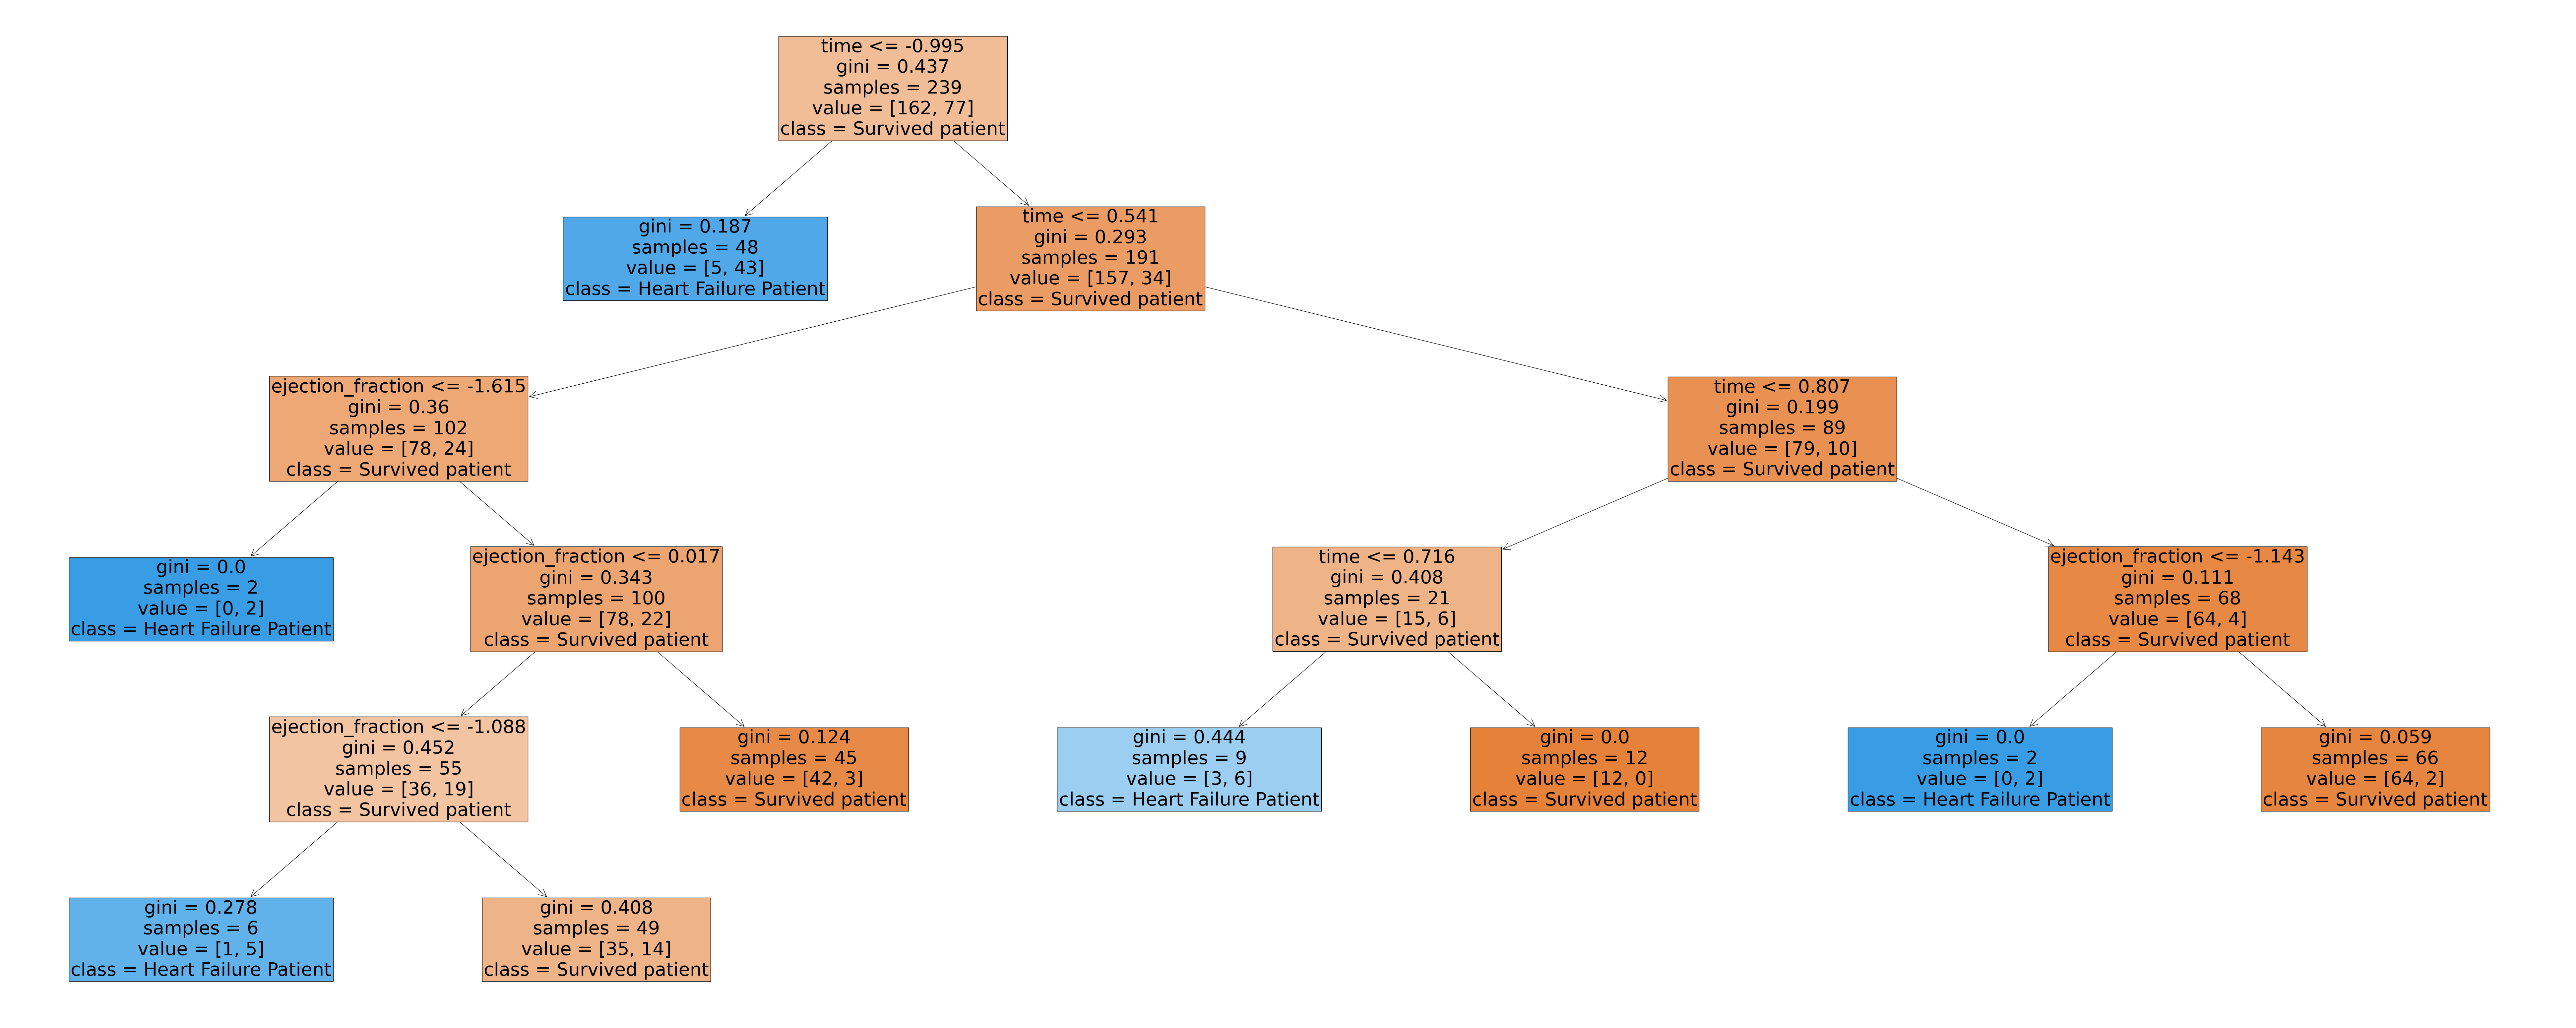

In [109]:
from sklearn import tree
import matplotlib.pyplot as plt

class_names = ["Survived patient", "Heart Failure Patient"]
y_train_named = y_train.replace({0: class_names[0], 1: class_names[1]})


_, ax = plt.subplots(figsize=(100, 40))
x = tree.plot_tree(
    best_models.get("Decision Tree").get("best_estimator"),
    feature_names=X_train_scaled.columns,
    class_names=class_names,
    filled=True,
    ax=ax,
    fontsize=40,
)

Attribute "time"

## B.9) Among the studied models, which one aims to define a hyperplane between two classes in order to maximize the margin of separation between them?

Among the studied models, the Support Vector Machine (SVM) aims to define a hyperplane between two classes in order to maximize the margin of separation between them. SVM is a powerful classification algorithm that seeks to find an optimal hyperplane that can effectively separate the data points of different classes while maximizing the distance between the hyperplane and the nearest data points from each class. This margin maximization helps in achieving better generalization and robustness of the model.

## B.10) Explain how the Naive Bayes technique can be considered a simplification of Bayes' Theorem.

The Naive Bayes technique can be considered as a simplification of Bayes' Theorem.

Bayes' Theorem is a fundamental principle in probability theory that describes how to update the probability of a hypothesis given new evidence. It calculates the conditional probability of a hypothesis (or an event) based on prior knowledge and observed evidence. Bayes' Theorem involves calculating probabilities using joint probabilities and conditional probabilities.

Naive Bayes, on the other hand, is a specific machine learning algorithm that is based on Bayes' Theorem. It simplifies the calculation by making a strong assumption of conditional independence among the features or attributes. This assumption implies that the presence or absence of a particular feature does not affect the presence or absence of other features.

By assuming independence among the features, Naive Bayes can calculate the posterior probability of a class given the observed evidence using simple multiplications of individual conditional probabilities. This simplifies the computation and allows for efficient and fast learning from large datasets.